In [81]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import yfinance as yf
import pandas_datareader.data as web

from typing import Tuple
import datetime

In [82]:
def plot_time_series( dates, title, xlabel, ylabel, **series ):
    """
    Plots a given time series

    Arguments:
    ----------
        series              : {array like}
                                > time series to plot
        dates               : {array like} 
                                > coresponding time of time series
        title (str)         : {string}
                                > plot title
        xlabel (str)        : {string}
                                > x-axis label
        ylabel (str)        : {string}
                                > y-axis label

    Returns:
    ----------
        fig                 : {figure}
                                > figure object of plot
    """
    # metadata
    names = series.keys()
    data = [x for x in series.values()]
    palette = ['#000000', '#58CCED', '#1261A0', '#072F5F']

    fig = go.Figure()

    for name, P, colour in zip(names, data, palette[:len(names)]):
        n_dates = len(dates)
        n_series = len(P)
        dif = n_dates - n_series
        fig.add_trace(go.Scatter(x=dates[dif:], y=P, mode='lines', name=name, line=dict(color=colour))) # Price series

    fig.update_layout(
        height = 500,
        title={'text': f"<b>{title}</b>", 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
        xaxis_title=f"{xlabel}",
        yaxis_title=f"{ylabel}",
        showlegend = True,
        legend_title_text='Series:',
        legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="right",
                    x=1
                ))

    return fig


# 1. Time Series Prep

**(a). Download S&P 500 ETF (called SPDR or Spider, ticker SPY Equity) at end-of-day prices for the period of time between 1 Jan 2014 to 31 Dec 2019. Download the Effective Fed Funds Rate (EFFR index) as the risk-free rate. Adjust the annual risk-free rate to make it daily rate. i.e $r_t^f = \text{EFFR}(t) \cdot dc$, where $dc$ is a day count. You can use $dc \approx (1/252)$**

**A unit of SPDR will cost $p_t$ at time $t$, which we have to finance at the risk-free rate. The daily excess return per unit of SPDR reads,**

$$ r_t^e = \frac{\Delta p_t}{p_t} - r_t^f $$

In [83]:
def get_closing_price_from_yfinance( 
        ticker_symbol : str, 
        start_date : datetime.datetime, 
        end_date : datetime.datetime
        ) -> pd.DataFrame:
    """
    Returns a pandas dataframe of the closing prices for a given stock ticker

    Arguments:
    ---------- 
    ticker_symbol   : {string}
                        > The stock ticker symbol 
    start_date      : {datetime.datetime}
                        > The start date of the data
    end_date        : {datetime.datetime}  
                        > The end date of the data
    
    Returns:
    ----------
    df              : {pandas.DataFrame}
                        > A pandas dataframe of the closing prices for the given stock ticker
    """
    # get data
    df = yf.download(ticker_symbol, start_date, end_date)

    # adjust index
    df.index = df.index.date
    
    
    return pd.DataFrame(df['Adj Close'])

[*********************100%***********************]  1 of 1 completed


''

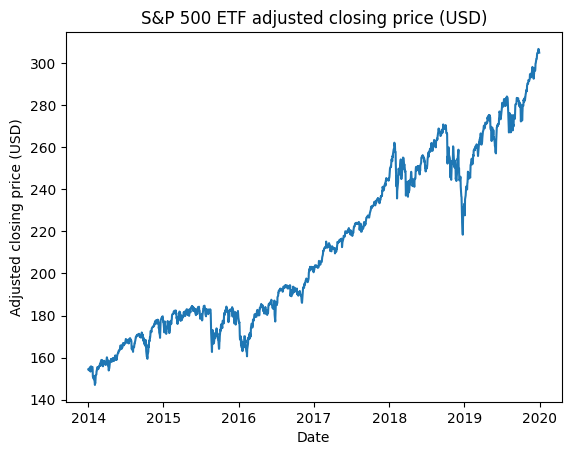

In [84]:
# download data
ticker_symbol = 'SPY'
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2019, 12, 31)

sp_500_etf_close = get_closing_price_from_yfinance(ticker_symbol, start_date, end_date)

# plot data
plt.plot(sp_500_etf_close)
plt.title('S&P 500 ETF adjusted closing price (USD)')
plt.xlabel('Date')
plt.ylabel('Adjusted closing price (USD)')
;

In [85]:
def get_effr_from_nyfed(
        start_date : datetime.datetime, 
        end_date : datetime.datetime,
        daily : bool = False,
        ) -> pd.DataFrame:
    """
    Returns a pandas dataframe of the effective federal funds rate 

    Arguments:
    ---------- 
    start_date      : {datetime.datetime}
                        > The start date of the data
    end_date        : {datetime.datetime}  
                        > The end date of the data
    daily           : {bool}
                        > Whether to return daily or annualised data
    
    Returns:
    ----------
    df              : {pandas.DataFrame}
                        > A pandas dataframe of the effective federal funds rate
    """
    # get data
    df = web.DataReader('EFFR', 'fred', start_date, end_date)

    # adjust index
    df.index = df.index.date

    if daily == True:
        # convert to % and ajust for 252 trading days
        df.columns = ['daily_effr']
        return df / (100*252)
    else:
        # convert to %
        df.columns = ['annual_effr']
        return df / 100


''

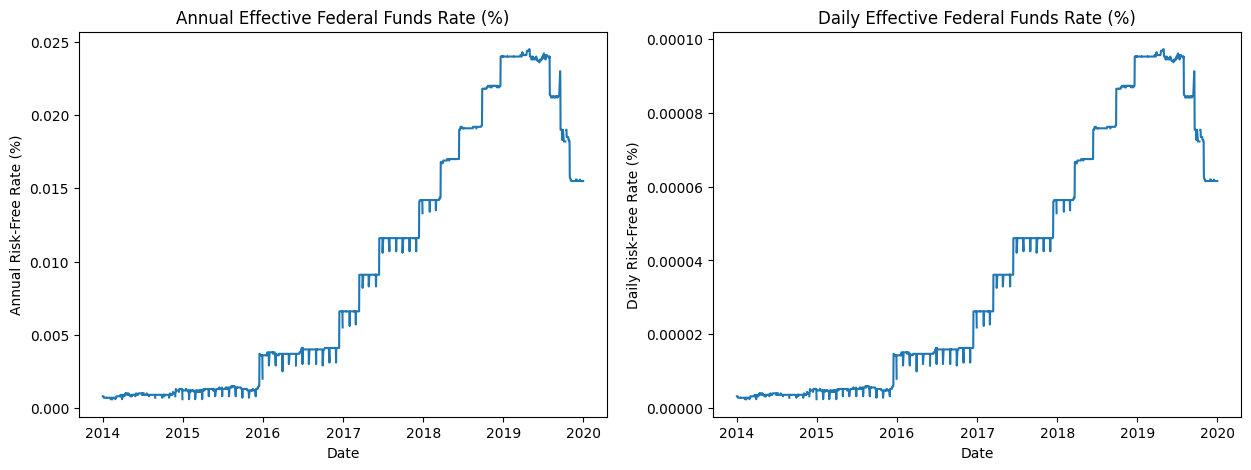

In [86]:
# get data
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2019, 12, 31)

annual_effr = get_effr_from_nyfed(start_date, end_date, daily=False)
daily_effr = get_effr_from_nyfed(start_date, end_date, daily=True)

# plot data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# annual EFFR
ax1.plot(annual_effr)
ax1.set_title('Annual Effective Federal Funds Rate (%)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Annual Risk-Free Rate (%)')

# daily EFFR
ax2.plot(daily_effr)
ax2.set_title('Daily Effective Federal Funds Rate (%)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Daily Risk-Free Rate (%)')
;

In [87]:
def get_daily_excess_return(
        closing_price : pd.DataFrame,
        daily_risk_free_rate : pd.DataFrame
) -> np.ndarray:
    """
    Returns a numpy array of the daily excess returns for a given stock and daily risk-free rate

    Arguments:
    ---------- 
    closing_price               : {pandas.DataFrame indexed by date}
                                        > A pandas dataframe of the closing prices for a given stock
    daily_risk_free_rate        : {pandas.DataFrame indexed by date}
                                        > A pandas dataframe of the daily risk-free rate
    
    Returns:
    ----------
    df                          : {pandas.DataFrame indexed by date}
                                        > A pandas dataframe for the daily excess returns for a given stock
    """
    # concatenate data
    data = pd.concat([closing_price, daily_risk_free_rate], axis=1)

    # drop na
    data = data.dropna()

    # get daily % change
    data['daily_returns'] = data['Adj Close'].pct_change()

    # get excess returns
    data['excess_returns'] = data['daily_returns'] - data['daily_effr']

    return pd.DataFrame(data['excess_returns']).fillna(0)

**(b). Plot the SPDR return time series, the EFFR, and the excess return per unit of SPDR, starting from t = 0 corresponding to 1 Jan 2014.**

Text(0, 0.5, 'Daily Excess Returns (%)')

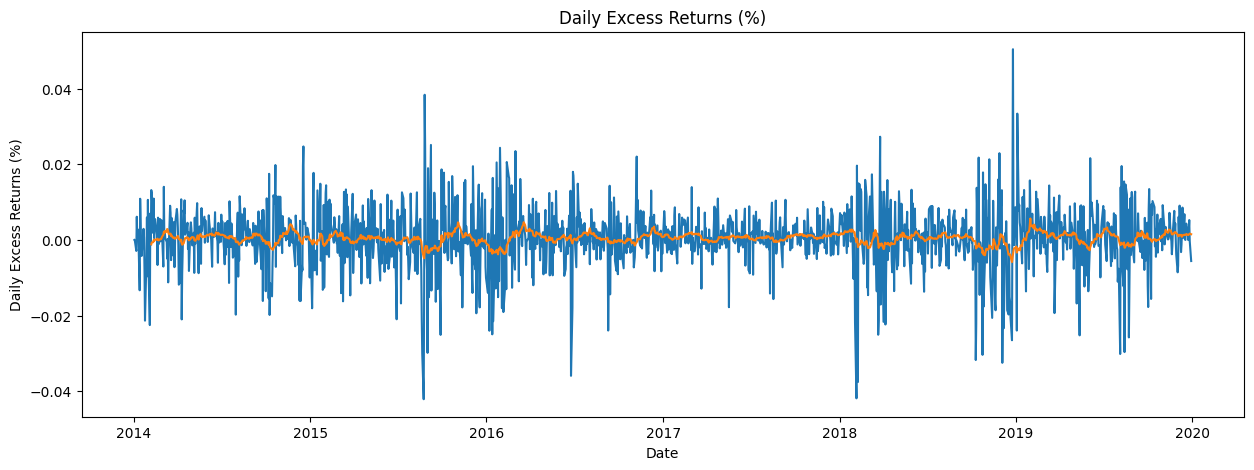

In [89]:
# get data
daily_excess_return = get_daily_excess_return(sp_500_etf_close, daily_effr)

# get moving average
daily_excess_return['moving_average'] = daily_excess_return['excess_returns'].rolling(25).mean()

# plot data
plt.figure(figsize=(15, 5))
plt.plot(daily_excess_return)
plt.title('Daily Excess Returns (%)')
plt.xlabel('Date')
plt.ylabel('Daily Excess Returns (%)')

# 2. Trading Strategies

**(Definition)**

**In a leveraged strategy, the (leveraged) book size is the available capital times the leverage amount. By a leveraged strategy we mean a sequence $\{ θ_t \}^T_{t=1}$ of dollar values of SPDR which can be long or short such that**

$$ | \theta_t | \leq V_t \cdot L $$

**where Vt is the total value of the holdings, and L is the leverage.**

**(a). Define three leveraged trading strategies for the SPDR with initial capital $V_0 = \text{\$}200, 000$. For all strategies, set the leverage $L = 5$. Use the first 70% of days as training set and the remaining 30% as test set. The daily trading PnL, which we define as the excess return of each strategy $\{θ_t\}^T_{t=1}$, is given by the equation:**

$$ \Delta V_t = \left( \frac{\Delta p_t}{p_t} - r_t^f \right) \cdot \theta_t $$

**where $θ_t$ is the dollar value of SPDR held at time $t$ (i.e; $θ_t = \text{units}(t) \cdot p_t$).**

**STRATEGY 1 : BUY N' HOLD**

**STRATEGY 2 : MOVING AVERAGE**

In [15]:
def get_bollinger_bands(
        data : pd.DataFrame, 
        window : int = 20, 
        std_dev : int = 2,
        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Computes the Bollinger pandas for a given time series

    Arguments:
    ----------
    data            : {pandas.DataFrame}
                        > A pandas dataframe of the closing prices for a given stock
    window          : {int}
                        > The rolling window for the Bollinger Bands
    std_dev         : {int}
                        > The number of standard deviations to use for the upper and lower bands
    
    Returns:
    ----------
    rolling_mean    : {numpy.ndarray}
                        > A numpy array of the rolling mean
    upper_band      : {numpy.ndarray}
                        > A numpy array of the upper band
    lower_band      : {numpy.ndarray}
                        > A numpy array of the lower band
    """
    # get mean and std
    rolling_mean = data['Adj Close'].rolling(window=window).mean()
    rolling_std = data['Adj Close'].rolling(window=window).std()

    # get bands
    upper_band = rolling_mean + (rolling_std * std_dev)
    lower_band = rolling_mean - (rolling_std * std_dev)

    return rolling_mean, upper_band, lower_band

Text(0, 0.5, 'Adjusted Closing Price (USD)')

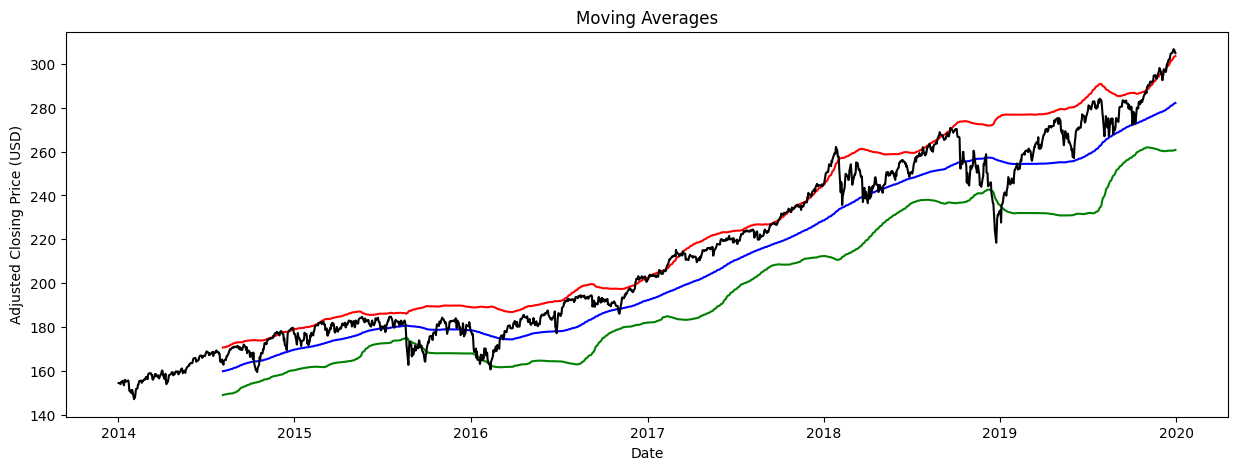

In [61]:
# plot bollinger bands
ma, upper, lower = get_bollinger_bands(data = sp_500_etf_close, window = 150, std_dev = 2)

fig = plt.figure(figsize=(15, 5))

plt.plot(ma, color = 'blue')
plt.plot(upper, color = 'red')
plt.plot(lower, color='green')
plt.plot(sp_500_etf_close, color='black')

plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price (USD)')

In [65]:
def moving_average_strategy(
        data : pd.DataFrame,
        window : int = 20,
        std_dev : int = 2,
        use_bollinger : bool = False,
        opening_position : int = 200000,
        leverage : float = 5.0,
        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Follows a moving average strategy for a given stock

    Arguments:
    ----------
    data            : {pandas.DataFrame}
                        > A pandas dataframe of the closing prices for a given stock
    window          : {int}
                        > The rolling window for the moving average
    std_dev         : {int}
                        > The number of standard deviations to use for the upper and lower bands
    use_bollinger   : {bool}
                        > Whether to use the Bollinger Bands or not
    """
    # get bollinger bands
    ma, upper, lower = get_bollinger_bands(data = data, window = window, std_dev = std_dev)

    # get series
    P = data.to_numpy().squeeze()
    N = len(P)

    # define portolio and cash
    V = np.zeros(N)
    cash = np.zeros(N)
    cash[0] = opening_position

    # define long and short levels based on Bollinger band use
    if use_bollinger:
        long_lvl = upper
        short_lvl = lower
    else:
        long_lvl = ma
        short_lvl = ma

    # loop through strategy 
    for i, p in enumerate(P[:-1]):

        if np.isnan(ma[i]):
            V[i+1] = V[i]
            cash[i+1] = cash[i]
            continue

        # Do nothing if the price is within the Bollinger Bands
        if (short_lvl[i] <= p) and (p <= long_lvl[i]):
            V[i+1] = V[i]
            cash[i+1] = cash[i]

        # Go long if the price crosses above the upper Bollinger Band
        if p > long_lvl[i]: 
            V[i+1] = cash[i]/p  + V[i]
            cash[i+1] = 0

        # Go short if the price crosses below the lower Bollinger Band
        if p < short_lvl[i]:
            cash[i+1] = V[i]*p + cash[i]
            V[i+1] = 0
        
    # get portfolio value
    portfolio_value = V*P + cash

    return portfolio_value

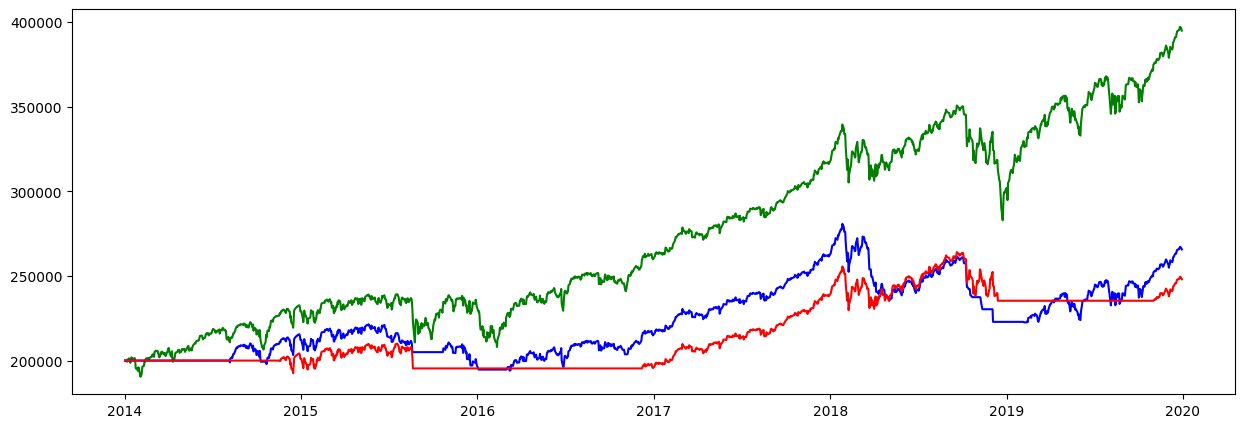

In [80]:
strategy = moving_average_strategy(
    data = sp_500_etf_close,
    window = 150,
    std_dev = 2,
    use_bollinger = False,
)

strategy_bollinger = moving_average_strategy(
    data = sp_500_etf_close,
    window = 150,
    std_dev = 2,
    use_bollinger = True,
)

dates = sp_500_etf_close.index
plt.figure(figsize=(15, 5))
plt.plot(dates, 200000*sp_500_etf_close['Adj Close']/sp_500_etf_close['Adj Close'][0], color = 'green')
plt.plot(dates, strategy, color = 'blue')
plt.plot(dates, strategy_bollinger, color = 'red')

**STRATEGY 3 : GAUSSIAN PROCESSES**